In [49]:
#Importando las librerías transversales (Data exploring)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Necesarias para el proceso de modelaje se utilizaran tres metodos para la detención de si fue un ataque o no basado en la literatura
from sklearn.svm import *
from sklearn.tree import *
from sklearn.linear_model import *
# Necesarias para el proceso de selección de variables
from sklearn.cluster import *
from sklearn.feature_selection import *
# Necesarios para procesos de mineria de datos
from fim import eclat

In [50]:
# Declaramos explicitamente los encabezados con sus respectivos tipos
header = ['timestamp', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed-label']
dtypes = {'timestamp': 'float', 'uid': 'string', 'id.orig_h': 'string', 'id.orig_p': 'Int64', 'id.resp_h': 'string', 'id.resp_p': 'Int64', 'proto': 'string', 'service': 'string', 'duration': 'float', 'orig_bytes': 'Int64', 'resp_bytes': 'Int64', 'conn_state': 'string', 'local_orig': 'boolean', 'local_resp': 'boolean', 'missed_bytes': 'Int64', 'history': 'string', 'orig_pkts': 'Int64', 'orig_ip_bytes': 'Int64', 'resp_pkts': 'Int64', 'resp_ip_bytes': 'Int64', 'tunnel_parents': 'string', 'label': 'string', 'detailed-label': 'string'}
# Lectura correspondiente del dataset
df = pd.read_csv('../data/conn.log.labeled', delimiter='\t', header=None, skiprows=8,na_values=['(empty)', '-'], keep_default_na=False, names=header, dtype=dtypes)
# Imprimimos las primeras filas del dataframe
display(df.head())

,timestamp,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.545404e+09,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,<NA>,3.139211,0,...,<NA>,0,S,3,180,0,0,- Benign -,,
1,1.545404e+09,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,<NA>,NaN,<NA>,...,<NA>,0,S,1,60,0,0,- Benign -,,
2,1.545404e+09,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,<NA>,NaN,<NA>,...,<NA>,0,S,1,60,0,0,- Benign -,,
3,1.545404e+09,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,...,<NA>,2896,ShADadttcfF,94,5525,96,139044,- Benign -,,
4,1.545404e+09,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,<NA>,3.147116,0,...,<NA>,0,S,3,180,0,0,- Benign -,,


In [51]:
# Observamos la forma original de nuestro dataset
df.shape

(23145, 23)

In [52]:
# Solucionamos el problema de tabulación del dataset que agrupa 3 columnas en una.
df[['tunnel_parents', 'label', 'detailed-label']] = df['tunnel_parents'].str.split(expand=True)

In [53]:
# Información de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       23145 non-null  float64
 1   uid             23145 non-null  string 
 2   id.orig_h       23145 non-null  string 
 3   id.orig_p       23145 non-null  Int64  
 4   id.resp_h       23145 non-null  string 
 5   id.resp_p       23145 non-null  Int64  
 6   proto           23145 non-null  string 
 7   service         1847 non-null   string 
 8   duration        5321 non-null   float64
 9   orig_bytes      5321 non-null   Int64  
 10  resp_bytes      5321 non-null   Int64  
 11  conn_state      23145 non-null  string 
 12  local_orig      0 non-null      boolean
 13  local_resp      0 non-null      boolean
 14  missed_bytes    23145 non-null  Int64  
 15  history         23145 non-null  string 
 16  orig_pkts       23145 non-null  Int64  
 17  orig_ip_bytes   23145 non-null 

### 1- NFS Limite definido
![NFS](../assets/NFS.png)

#### 1.1 Descubriendo patrones de las transacciones (Conexiones en la red) con la tecnica FIM

In [54]:
transactions = []
for index, row in df.iterrows():
    # Crear una lista de valores no nulos para cada fila del dataframe
    transaction = [str(val) for val in row.values if pd.notnull(val)]
    transactions.append(transaction)

# Aplicar FIM utilizando el algoritmo ECLAT
# 'm' significa encontrar patrones maximales es decir, patrones que no están contenidos en otros patrones más grandes.
# '2' soporte mínimo que se busca para los patrones que aparezcan en más de dos transacciones
patterns = eclat(transactions, target='m', supp=2)

# Imprimir los patrones frecuentes y su soporte
for pattern, support in patterns:
    print(pattern, support)


('8', '192.168.1.195', '-', '0') 463
('48', '147.231.100.5', '192.168.1.195', '-', '0', '1', 'Benign', 'udp', '123', '76', 'SF', 'Dd') 702
('589', 'ShAdDaf', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '185.244.25.235', '6667', 'C&C', 'irc', 'S3', '6', '62', '269') 518
('D', '76', '192.168.1.195', '-', '0', 'S0', 'udp', '1', 'Benign', '123') 823
('563', 'ShAdDaf', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '185.244.25.235', '6667', 'C&C', 'irc', 'S3', '6', '75', '243') 702
('7', '243', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '185.244.25.235', '6667', 'C&C', 'irc', 'S3', '75') 463
('7', '6', 'ShAdDaf', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '185.244.25.235', '6667', 'C&C', 'irc', 'S3') 537
('60', '1', 'S', 'C&C', '192.168.1.195', '-', 'tcp', '185.244.25.235', '0', 'S0', 'Malicious', '6667') 2412
('180', 'C&C', '192.168.1.195', '-', '0', 'tcp', '185.244.25.235', 'S0', 'S', '3', 'Malicious', '6667') 2650
('65279', 'C', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '

#### 1.2 Visualizar los soportes con respecto de los patrones encontrados

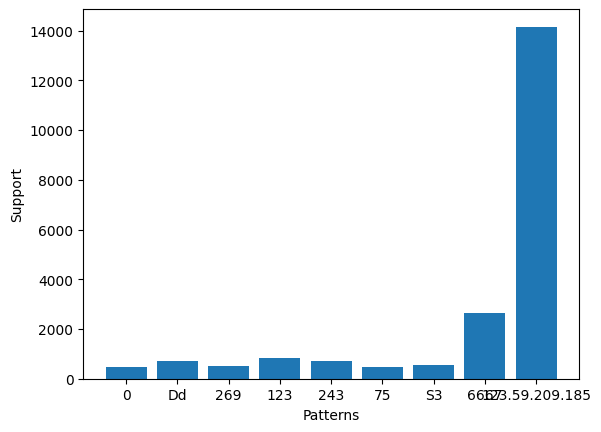

In [55]:
# Convertir los datos en un array de tipo object
data_array = np.array(patterns, dtype=object)
strings = []
for tupla in data_array[:,0]:
    # Convertir el ultimo caracter de la tupla a un string para mejorar la visualización utilizando join()
    string = ''.join(map(str, tupla[-1]))
    strings.append(string)
# Graficar los datos como una gráfica de barras
plt.bar(strings, data_array[:,1])
plt.xlabel('Patterns')
plt.ylabel('Support')
plt.show()

#### 1.3 Obtener el valor de frecuencia del patrón más dominante

In [56]:
# Calcular la frecuencia dominante
total = sum([support for _, support in patterns])
dominant_frequency = max([support / total for _, support in patterns])
# Imprimir la frecuencia
print("Frecuencia dominate:", dominant_frequency)

Frecuencia dominate: 0.6043365060395237


#### 1.4 Encontrar la lista de variables valiosas que esten por encima del umbral predifinido

In [99]:
# Seleccionar características con frecuencia por encima del umbral
selected_features = []
for pattern, support in patterns:
    # Limite definido por conocimiento de experto
    if support / total >= 0.5:
        selected_features.extend(pattern)
print('Patron Sleccionado', selected_features)
keys = ['id.orig_p', 'history', 'id.orig_h','label', 'orig_pkts', 'proto','label', 'id.resp_p','detailed-label', 'conn_state', 'id.resp_h']

Patron Sleccionado ['65279', 'C', '192.168.1.195', '-', '0', 'tcp', 'Malicious', '80', 'DDoS', 'OTH', '123.59.209.185']


In [98]:
# Visualizar Reduced features data con limite definido
display(df[keys].head())

,id.orig_p,history,id.orig_h,label,orig_pkts,proto,label,id.resp_p,detailed-label,conn_state,id.resp_h
0,41040,S,192.168.1.195,Benign,3,tcp,Benign,80,-,S0,185.244.25.235
1,41040,S,192.168.1.195,Benign,1,tcp,Benign,80,-,S0,185.244.25.235
2,41040,S,192.168.1.195,Benign,1,tcp,Benign,80,-,S0,185.244.25.235
3,41040,ShADadttcfF,192.168.1.195,Benign,94,tcp,Benign,80,-,SF,185.244.25.235
4,41042,S,192.168.1.195,Benign,3,tcp,Benign,80,-,S0,185.244.25.235


### 2- Feature Selection with k-means
![NFS](../assets/WFS.png)

### 2- Sin Limite definido

#### 2.1 Extraemos la muestra del conjunto de datos iterando a través de cada valor de característica y extrayendo las frecuencias de patrones más dominantes.

In [81]:
# Por temas de visualizacion posteriores 
table_data = []
for feature_name in df.columns:
    max_count = 0
    feature_v = 0
    feature_cnts = df[feature_name].value_counts().to_dict()
    # Contar la cantidad de valores únicos en la columna
    for uniq_v in feature_cnts.keys():
        v_count = feature_cnts.get(uniq_v)
        if v_count > max_count:
            max_count = v_count
            feature_v = uniq_v
    table_data.append([feature_name, feature_v,max_count, (max_count/len(df))*100])


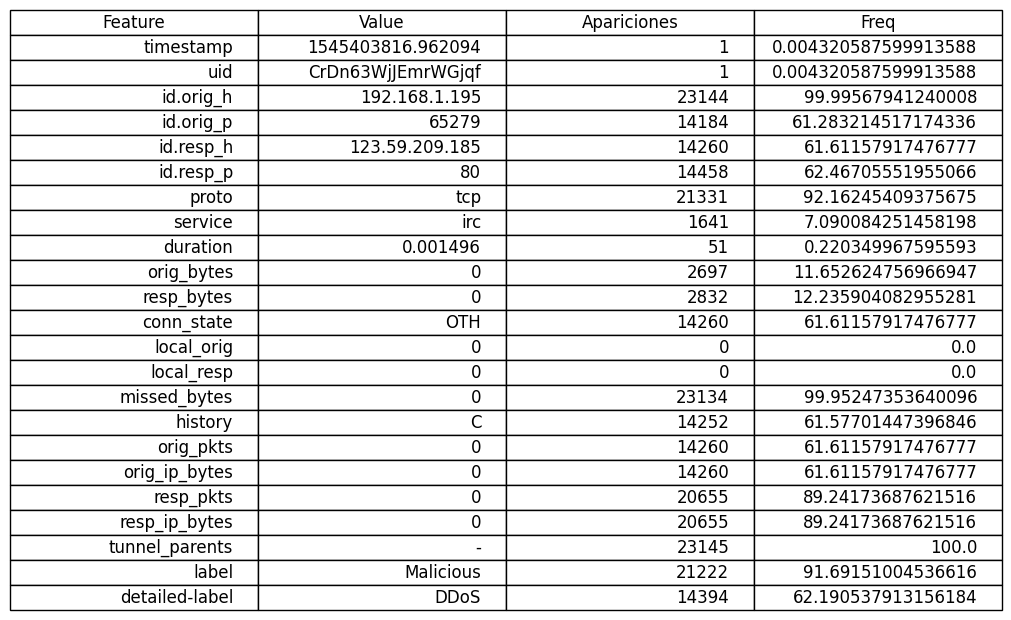

In [82]:
fig, ax = plt.subplots()
table = ax.table(cellText=table_data, colLabels=['Feature', 'Value','Apariciones', 'Freq'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2, 1.5)
ax.axis('off')
plt.show()

#### 2.2 Filtramos features que se encuentren por debajo del umbral definido

In [96]:
# Convertir la lista en un array de NumPy
feature_values = np.array(table_data)
# Filtrar lista
feature_values = feature_values[np.where(feature_values[:, 3].astype(float)  > 50)]
# Nuestro componente de feature sample extractor no elimina variaables que no se encuentre por tanto:
featureValuesDf = df.drop(["local_orig", "local_resp", 'uid', 'timestamp', 'service', 'duration', 'orig_bytes', 'resp_bytes'], axis=1)
# Nota quedamos con las siguientes 15 features
display(featureValuesDf.head())

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,192.168.1.195,41040,185.244.25.235,80,tcp,S0,0,S,3,180,0,0,-,Benign,-
1,192.168.1.195,41040,185.244.25.235,80,tcp,S0,0,S,1,60,0,0,-,Benign,-
2,192.168.1.195,41040,185.244.25.235,80,tcp,S0,0,S,1,60,0,0,-,Benign,-
3,192.168.1.195,41040,185.244.25.235,80,tcp,SF,2896,ShADadttcfF,94,5525,96,139044,-,Benign,-
4,192.168.1.195,41042,185.244.25.235,80,tcp,S0,0,S,3,180,0,0,-,Benign,-


#### 2.2 Luego partiendo de las dos target clases (Malicioso, Normal) sacamos el puntaje de impuridad de Gini.

TypeError: 'enumerate' object is not subscriptable

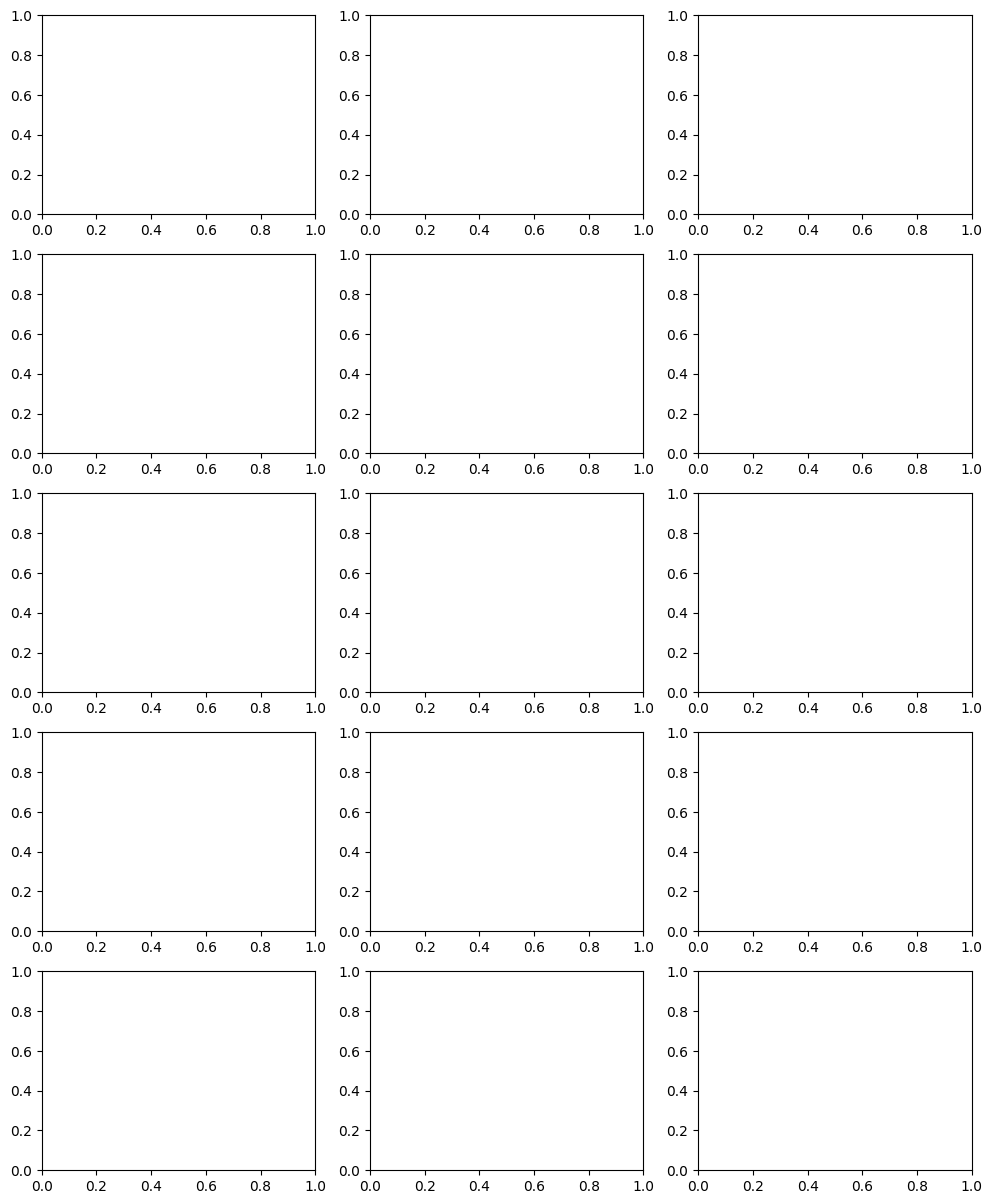

In [114]:
output = []
# Crear subplots
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))
for index, feature_name in enumerate(featureValuesDf.columns):
    max_count = feature_values[index][2]
    feature_v = feature_values[index][1]
    # Crear un subconjunto del dataframe con la columna y el valor más frecuente
    datas = featureValuesDf[featureValuesDf[feature_name] == feature_v]
    # Calcular el índice Gini del subconjunto partiento de la columna de etiqueta que contiene las dos target clases
    p = datas['label'].value_counts(normalize=True)
    (enumerate(axs.flatten())[index]).plot(p.index, p.values)
    (enumerate(axs.flatten())[index]).set_title(f'Gráfico {index +1}')
    gini = 1 - (p ** 2).sum()
    output.append([feature_name, feature_v, gini])
# Ajustar diseño
plt.tight_layout()
# Mostrar gráfico
plt.show()
# Retornar la lista de patrones y sus puntajes
print(output)

#### 2.2 Visualizar puntaje de impureza para cada feature

<Figure size 640x480 with 0 Axes>

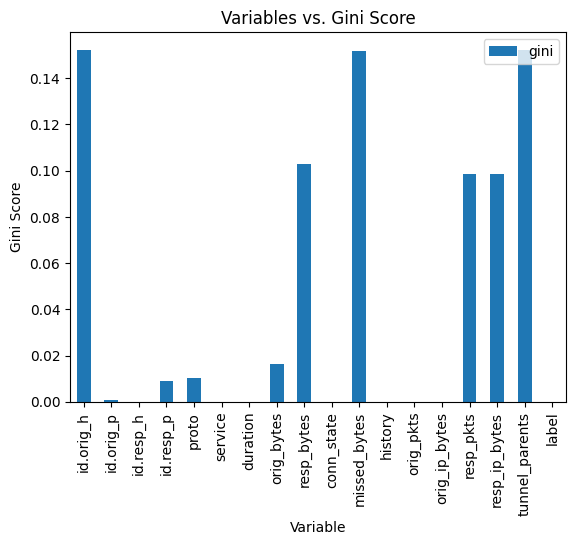

In [72]:
# Convertir a dataframe de pandas
dfGini = pd.DataFrame(output, columns=['column', 'value', 'gini'])
# Plotear
plt.figure()
dfGini.plot(x='column', y='gini', kind='bar')
plt.xlabel('Variable')
plt.ylabel('Gini Score')
plt.title('Variables vs. Gini Score')
plt.show()

#### 2.3 Algoritmo de K-Means para automatizar la selección de variables

In [60]:
"""
The following script takes in a csv file and a file name containing column names to keep and filter out the rest from the dataset.
The dataset name and the filter list file names are passed as command line arguments.
Usage:
>>> python K-Means-Clustering.py predictors_score_file K predictors_start_ID number_of_columns
 --> predictors_score_file - The file containing feature scores for feature selection such as chi-sqaure score.
 --> K - number of clusters for K Means clustering algorithm.
 --> predictors_start_ID - Column ID for the starting column with score.
 --> number_of_columns - number of columns for K Means clustering to use.
 --> output filename for predictors identified based either on minimum or maximum score.
"""
data = output
k = 2 # Assign K for K-Means clustering algorithm
predictor_column_ID = 3 # Assign Initial predictor column ID
column_predictors = 5 # Assign number of columns containing predictor scores (predictors)

x = data.iloc[:,predictor_column_ID:predictor_column_ID+column_predictors] # Extract Feature estimator score, this could be multiple rows (for example data.iloc[:,2:4] assuming there are two columns predictors: column 2 and 3)

kmeans = KMeans(k)
kmeans.fit(x)

identified_clusters = kmeans.fit_predict(x)
PREDICTOR_SCORE_COLUMN = 2
PREDICTOR_NAME_COLUMN = 0
i = 0

clusters = [[] for j in range(k)]
min_value = data.iloc[i,PREDICTOR_SCORE_COLUMN]
min_cluster = 0
for item in identified_clusters:
    clusters[item].append(data.iloc[i,PREDICTOR_NAME_COLUMN])
    if(data.iloc[i,PREDICTOR_SCORE_COLUMN]<min_value):
        min_cluster = item
        min_value = data.iloc[i,PREDICTOR_SCORE_COLUMN]
    i += 1

#Print the best cluster predictors identified.    
print('The column names identified are:')
print(clusters)

AttributeError: 'list' object has no attribute 'iloc'